# Projet 5 - Segmentez des clients d'un site e-commerce

In [2]:
# Imports nécessaires
import sys  # Python v3.12.4
import pandas as pd  # 2.2.3
import numpy as np  # 2.1.2
import matplotlib.pyplot as plt
import seaborn as sns  # 0.13.2
import missingno as msno  # 0.5.2
import datetime as dt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [3]:
# Paramètre d'affichage
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
# Affichage des versions des librairies
print("Version des librairies :")
print(f"Python        : {sys.version}")
print(f"Pandas        : {pd.__version__}")
print(f"NumPy         : {np.version.__version__}")
print(f"Seaborn       : {sns.__version__}")
print(f"missingno     : {msno.__version__}")

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.3
NumPy         : 2.0.2
Seaborn       : 0.13.2
missingno     : 0.5.2


## Fonction Utilitaires

In [ ]:
def df_periode(df, delta):
    """
    Filtre les données sur une période spécifique.
    """
    date_min = df["order_purchase_timestamp"].dt.date.min()
    week = 52 + (delta * 2)
    date_max = date_min + dt.timedelta(weeks=week)

    df_delta = df[
        (df["order_purchase_timestamp"].dt.date >= date_min) &
        (df["order_purchase_timestamp"].dt.date <= date_max)
    ].copy()
    return df_delta

def df_agg_client(df):
    """
    Agrège les données par client.
    """
    df = df.copy()
    date_max = df["order_purchase_timestamp"].max()

    df["mean_shipping_time"] = (
        df["order_delivered_customer_date"] - df["order_purchase_timestamp"]
    ).dt.days
    df["mean_delivery_delay"] = (
        df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
    ).dt.days

    agg_data = df.groupby("customer_unique_id").agg(
        order_purchase_timestamp=("order_purchase_timestamp", "max"),
        order_delivered_customer_date=("order_delivered_customer_date", "max"),
        order_estimated_delivery_date=("order_estimated_delivery_date", "max"),
        time_since_first_order=("order_purchase_timestamp", lambda x: (date_max - x.min()).days),
        time_since_last_order=("order_purchase_timestamp", lambda x: (date_max - x.max()).days),
        mean_shipping_time=("mean_shipping_time", "mean"),
        mean_delivery_delay=("mean_delivery_delay", "mean"),
        customer_city=("customer_city", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        customer_state=("customer_state", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        nb_total_order=("order_id", "count"),
        nb_total_item=("product_id", "count"),
        total_price=("price", "sum"),
        mean_price=("price", "mean"),
        total_freight_value=("freight_value", "sum"),
        mean_freight_value=("freight_value", "mean"),
        payment_type=("payment_type", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        mean_payment_installments=("payment_installments", "mean"),
        total_payment_value=("payment_value", "sum"),
        mean_payment_value=("payment_value", "mean"),
        mean_review_score=("review_score", "mean"),
        seller_city=("seller_city", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        seller_state=("seller_state", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        cat=("product_category_name_english", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    )
    return agg_data

def model_init(data, col, delta):
    """
    Initialise le modèle de clustering et le préprocesseur.
    """
    df_init = df_periode(data, delta)
    df_agg = df_agg_client(df_init)
    df_agg = df_agg[col].copy()

    col_quanti = df_agg.select_dtypes(include=["int64", "float64"]).columns
    col_quali = df_agg.select_dtypes(include=["category", "object", "bool"]).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ("quanti", MinMaxScaler(), col_quanti),
            ("quali", OneHotEncoder(handle_unknown="ignore"), col_quali)
        ],
        remainder="passthrough"
    )

    df_scaled = preprocessor.fit_transform(df_agg)

    kmeans = KMeans(
        n_clusters=5,
        init="k-means++",
        n_init="auto",
        algorithm="lloyd",
        random_state=77
    )
    kmeans.fit(df_scaled)
    df_agg["Cluster"] = kmeans.predict(df_scaled)

    return preprocessor, kmeans

def model_periode(data, col, k, p_min, p_max, preprocessor, model_initial):
    """
    Calcule les scores ARI pour différentes périodes.
    """
    ARI = []

    for p in range(p_min, p_max + 1):
        df_p = df_periode(data, p)
        df_p = df_agg_client(df_p)
        df_p = df_p[col].copy()

        df_scaled = preprocessor.transform(df_p)
        df_p["Cluster_initial"] = model_initial.predict(df_scaled)

        kmeans_period = KMeans(
            n_clusters=k,
            init="k-means++",
            n_init="auto",
            algorithm="lloyd",
            random_state=77
        )
        kmeans_period.fit(df_scaled)
        df_p["Cluster"] = kmeans_period.predict(df_scaled)

        score_ari = adjusted_rand_score(df_p["Cluster"], df_p["Cluster_initial"])
        ARI.append([p, score_ari])

    return ARI

def plot_ari(ARI, title):
    """Affiche l'évolution du score ARI."""
    df_ARI = pd.DataFrame(ARI, columns=["Période", "Score"])

    plt.figure(figsize=(15, 7))
    sns.lineplot(x=df_ARI["Période"] * 2, y=df_ARI["Score"] * 100, marker="o")

    for line in range(0, df_ARI.shape[0]):
        plt.text(
            x=df_ARI.Période[line] * 2 + 0.3,
            y=df_ARI.Score[line] * 100,
            s=(df_ARI.Score[line] * 100).round(2)
        )

    plt.axhline(y=80, color="gray", linestyle="--")
    plt.xticks(range(0, 50, 2))
    plt.xlabel("Semaines")
    plt.ylabel("Score ARI (en %)")
    plt.title(title)
    plt.grid()
    plt.show()

# Chargement du dataset DATA

In [6]:
# Chargement des données
data = pd.read_csv("data.csv")

In [7]:
# Conversion des dates
col_date = [
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date", "shipping_limit_date"
]
data[col_date] = data[col_date].apply(pd.to_datetime, errors="coerce")

In [8]:
# Conversion des colonnes catégoriques
col_cat = [
    "order_status", "customer_zip_code_prefix", "customer_city",
    "customer_state", "payment_type", "seller_zip_code_prefix",
    "seller_city", "seller_state", "product_category_name_english"
]
data[col_cat] = data[col_cat].astype("category")

In [9]:
# Vérification des dates min/max
max_date = data["order_purchase_timestamp"].max()
min_date = data["order_purchase_timestamp"].min()
print(f"La date de début commence le {min_date} et elle se termine le {max_date}")

La date de début commence le 2016-10-03 09:44:50 et elle se termine le 2018-08-29 15:00:37


In [10]:
# Initialisation du modèle
col_select = [
    "time_since_last_order", "mean_shipping_time", "nb_total_order",
    "nb_total_item", "total_price", "mean_freight_value",
    "mean_payment_installments", "mean_review_score"
]
preprocessor, kmeans = model_init(data, col_select, 0)

### Graphiques et scores ARI

Scores ARI pour les premières périodes :


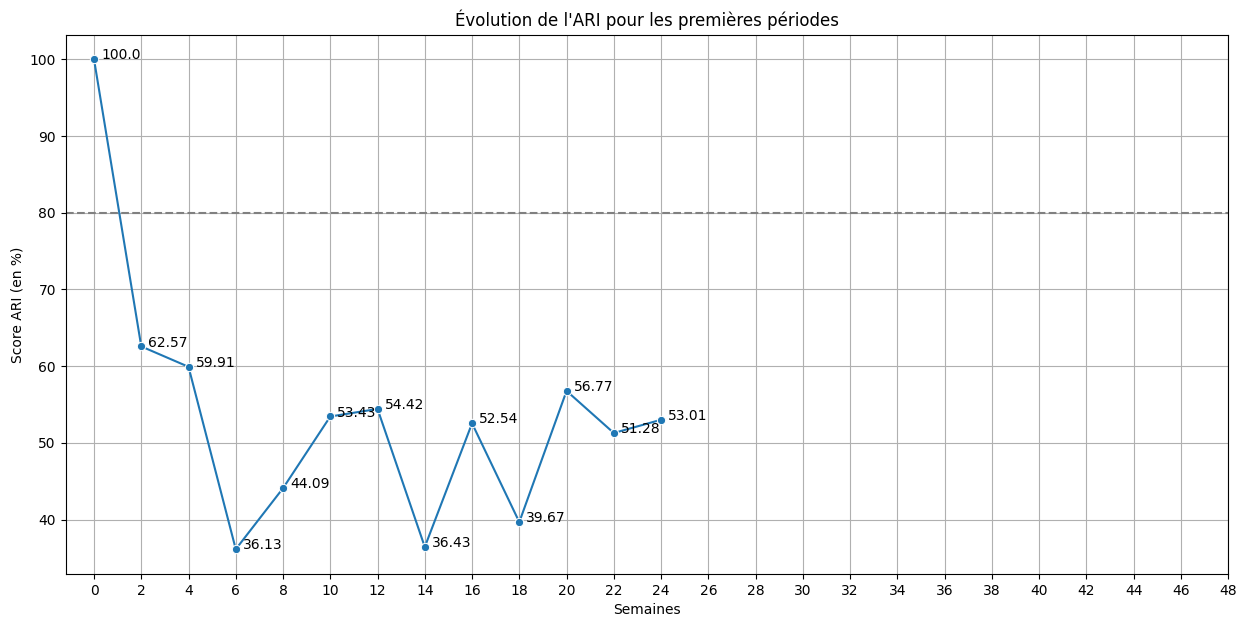

In [11]:
# Premier calcul des scores ARI
ARI_1 = model_periode(data, col_select, 5, 0, 12, preprocessor, kmeans)
print("Scores ARI pour les premières périodes :")
plot_ari(ARI_1, "Évolution de l'ARI pour les premières périodes")

Scores ARI pour les secondes périodes :


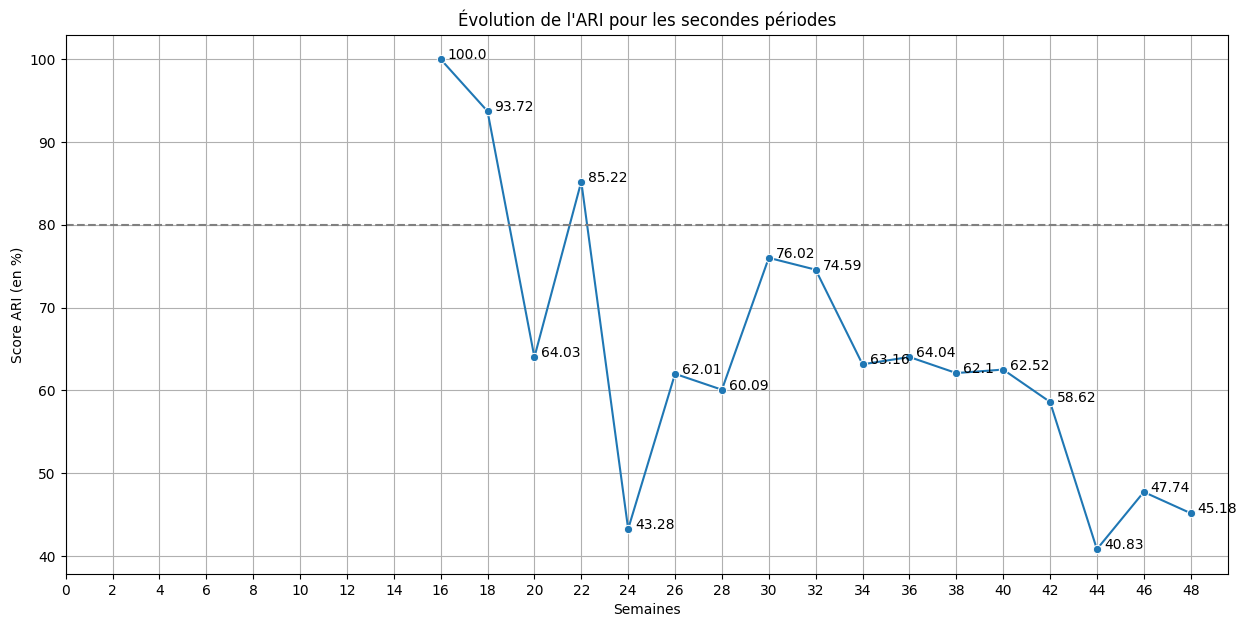

In [12]:
# Second calcul des scores ARI
preprocessor_2, kmeans_2 = model_init(data, col_select, 8)
ARI_2 = model_periode(data, col_select, 5, 8, 24, preprocessor_2, kmeans_2)
print("Scores ARI pour les secondes périodes :")
plot_ari(ARI_2, "Évolution de l'ARI pour les secondes périodes")


# <u>**Conclusions**</u>    

Premières périodes (graphique 1) :    

- Les scores ARI montrent une chute rapide dès les premières semaines.
- Après 6 semaines, les scores oscillent entre 35% et 55%, cela pourrait suggérer une faible stabilité des clusters au fil du temps.

Deuxième périodes (graphique 2) :    

- Le scores débute à 100% mais il diminuent progressivement.
- Après la semaine 22, les scores fluctuent autours des des 60%, puis ils chutent en dessous de 50% à partir de la semaine 43.

___
Compte tenu des informations obtenu avec ces graphiques, j'aurai conseillé une fréquence de maintenance entre 5 et 6 semaines car les scores chutent après ce délai dans les deux périodes.    
Cette intervale évite que la qualité des clusters ne se dégrade trop (score ARI chutant en dessous de 50-60%).    

Mais en prenant en considération l'évolution des commandes observé lors de l'analyse exploratoire, je recommande une fréquence de maintenance de 2 à 3 semaines.
___